<a href="https://colab.research.google.com/github/sebatlab/Antaki2021/blob/main/brainspan_analysis_2021_12_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Polygon
import scipy.stats
import numpy as np
import itertools
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !ls "/content/drive/My Drive/antaki2021_manuscript/brainspan/"
df = pd.read_csv("/content/drive/My Drive/antaki2021_manuscript/brainspan/full_brainspan_table_final_normalized.tsv.gz", sep = '\t')

In [4]:
not_cortex = [
    'amygdaloid complex',
    'cerebellum',
    'hippocampus (hippocampal formation)',
    'mediodorsal nucleus of thalamus',
    'striatum',
]

# omit regions that are NOT in cortex
df = df[~df['structure_name'].isin(not_cortex)]

In [5]:
# list of TADA genes generated 2021_11_19 (q threshold of < 0.05, don't apply LOEUF or pLI filters)
ta = pd.read_csv("/content/drive/My Drive/antaki2021_manuscript/brainspan/tada_input_and_results_2021_11_18.qval_0.05_.csv", sep = "\t")
tada_genes = list(ta["gene"])

# gwas genes given to us by authors (processed by MAGMA?)
gwas_genes_new = pd.read_csv("/content/drive/My Drive/antaki2021_manuscript/brainspan/Disorder_associated_genes.csv", header = None, names = ["gene"])
magma_genes = list(set(gwas_genes_new["gene"]))

# brainspan protein coding genes
df_brainspan_protein_coding = pd.read_csv("/content/drive/My Drive/antaki2021_manuscript/brainspan/brainspan_genes.gencode.protein_coding.txt",
                                          sep = "\t", header = None,
                                          names = ["chromosome_name", "feature_type", "genomic_start_location", "genomic_end_location", "gene_name_key", "gene", "gene_type_key", "gene_type"])
brainspan_protein_coding_genes = list(set(df_brainspan_protein_coding["gene"]))

In [6]:
with open("/content/drive/My Drive/antaki2021_manuscript/brainspan/brainspan_cortex_protein_coding.1000_random_sample.seed_0.txt") as f:
    brainspan_protein_coding_genes_random_sample = f.read().splitlines()

In [7]:
# only include tada_genes, magma_genes, brainspan_protein_coding_genes
df = df[df['gene'].isin(tada_genes + magma_genes + brainspan_protein_coding_genes)]

# for the LOWESS curve
def convert_to_weeks(date_string):
    value, sfx = date_string.split(' ') 
    if sfx == 'pcw':
        value = float(value)
    if sfx == 'mos':
        value = (int(value)*4)+40.
    if sfx == 'yrs':
        value = (int(value)*52.)+40.
    return value

df['weeks'] = df['age'].apply(convert_to_weeks)

Figure 7a

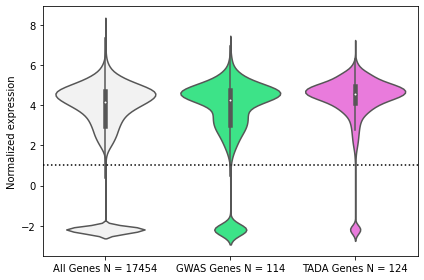

In [8]:
# Analysis
# t-test comparisons
tada_magma_ttest = scipy.stats.ttest_ind(df[(df["gene"].isin(tada_genes))]["norm"], df[(df["gene"].isin(magma_genes))]["norm"])
magma_brainspan_ttest = scipy.stats.ttest_ind(df[(df["gene"].isin(magma_genes))]["norm"], df[(df["gene"].isin(brainspan_protein_coding_genes))]["norm"])

# 1-sample t-tests (not necessary?)
# tada_ttest = scipy.stats.ttest_1samp(df[(df["gene"].isin(tada_genes))]["norm"], 0.)
# gwas_ttest = scipy.stats.ttest_1samp(df[(df["gene"].isin(gwas_genes))]["norm"], 0.)
# magma_ttest = scipy.stats.ttest_1samp(df[(df["gene"].isin(magma_genes))]["norm"], 0.)


# get the normalized expressions for each type
df_tada_expression  = pd.DataFrame(df[(df["gene"].isin(tada_genes))]["norm"]).rename(columns = {"norm": "normalized_expression"})
df_tada_expression["label"] = "tada"

df_gwas_expression = pd.DataFrame(df[(df["gene"].isin(magma_genes))]["norm"]).rename(columns = {"norm": "normalized_expression"})
df_gwas_expression["label"] = "magma"

df_brainspan_protein_coding_expression = pd.DataFrame(df[(df["gene"].isin(brainspan_protein_coding_genes))]["norm"]).rename(columns = {"norm": "normalized_expression"})
df_brainspan_protein_coding_expression["label"] = "brainspan_cortex_protein_coding"

# concatenate expressions
df_expressions = pd.concat([df_brainspan_protein_coding_expression, df_gwas_expression, df_tada_expression]).reset_index(drop = True)

# gene counts per label
num_tada_genes = len(df[(df["gene"].isin(tada_genes))]["gene"].unique())
num_magma_genes = len(df[(df["gene"].isin(magma_genes))]["gene"].unique())
num_brainspan_genes = len(df[(df["gene"].isin(brainspan_protein_coding_genes))]["gene"].unique())
num_brainspan_genes_rs = len(df[(df["gene"].isin(brainspan_protein_coding_genes_random_sample))]["gene"].unique())

# Plotting
# figure 7a
"""Genes across all time points"""
f, ax = plt.subplots()
sns.violinplot(
    data = df_expressions,
    x = 'label',
    y = 'normalized_expression',
    palette = ['#f2f2f2', '#21ff85', '#fc68ea'],
    ax = ax,
    scale = 'width',
)

xmin, xmax = ax.set_xlim()
ax.hlines(y = 1, xmin = xmin, xmax = xmax, linestyles = ':', color = 'k')
ax.set(
    xlabel = '',
    ylabel = 'Normalized expression',
    xticklabels = ['All Genes N = {}'.format(num_brainspan_genes), 'GWAS Genes N = {}'.format(num_magma_genes), 'TADA Genes N = {}'.format(num_tada_genes)]
)
f.tight_layout()
f.savefig('fig7a.svg')

In [9]:
def lowess(df, f = 1./3.):
    # import pdb; pdb.set_trace()
    """
    Basic LOWESS smoother with uncertainty. 
    Note:
        - Not robust (so no iteration) and
             only normally distributed errors. 
        - No higher order polynomials d = 1 
            so linear smoother.
    """
    x = np.array(df['weeks'])
    y = np.array(df['norm_gene'])
    # Get some paras
    xwidth = f*(x.max() - x.min()) # Effective width after reduction factor
    N = len(x) # Number of observations
    # Don't assume the data is sorted
    order = np.argsort(x)
    # Storage
    y_sm = np.zeros_like(y)
    y_stderr = np.zeros_like(y)
    # Define the weighting function -- clipping too!
    # tricube = lambda d : np.clip((1 - np.abs(d)**3)**3, 0, 1) # slow
    tricube = lambda d : np.clip((1 - np.abs(d)*np.abs(d)*np.abs(d))*(1 - np.abs(d)*np.abs(d)*np.abs(d))*(1 - np.abs(d)*np.abs(d)*np.abs(d)), 0, 1)
    # Run the regression for each observation i

    A = np.zeros((df.shape[0], 2))
    w = np.zeros((df.shape[0],))

    for i in range(N):
        dist = np.abs((x[order][i] - x[order]))/xwidth
        w = tricube(dist)
        # Form linear system with the weights
        A = np.stack([w, x[order]*w]).T
        b = w * y[order]
        ATA = A.T.dot(A)
        ATb = A.T.dot(b)
        # Solve the system
        sol = np.linalg.solve(ATA, ATb)
        # Predict for the observation only
        yest = A[i].dot(sol) # Equivalent of A.dot(yest) just for k
        place = order[i]
        y_sm[place] = yest 
        # sigma2 = (np.sum((A.dot(sol) - y[order])**2)/N) # slow
        sigma2 = (np.sum((A.dot(sol) - y[order])*(A.dot(sol) - y[order]))/N)
        # Calculate the standard error
        y_stderr[place] = np.sqrt(sigma2 * 
                                A[i].dot(np.linalg.inv(ATA)
                                                    ).dot(A[i]))
    df['norm_lowess'] = y_sm
    df['norm_lowess_stderr'] = y_stderr
    return df.copy()
     
def scale(y, c = True, sc = False):
    x = y.copy()

    if c:
        x -= x.mean()
    if sc and c:
        x /= x.std()
    elif sc:
        x /= np.sqrt(x.pow(2).sum().div(x.count() - 1))
    return x

# scale by gene (row)
df['norm_gene'] = df.groupby(['gene'])['norm'].apply(scale)
# adding one because that's how we scaled sample-wise (column)
df['norm_gene'] += 1

In [ ]:
tada_df = df[df['gene'].isin(tada_genes)].copy()
magma_df = df[df['gene'].isin(magma_genes)].copy()
# brainspan_df = df[df['gene'].isin(brainspan_protein_coding_genes)].copy()
brainspan_sample_df = df[df['gene'].isin(brainspan_protein_coding_genes_random_sample)].copy()

In [ ]:
# profiling LOWESS smoother
!pip install line_profiler
%load_ext line_profiler
%lprun -f lowess lowess(brainspan_sample_df)

# debugging
# %debug 
# brainspan_sample_df = lowess(brainspan_sample_df)

In [ ]:
# slowest part
tada_df = lowess(tada_df)
magma_df = lowess(magma_df)
brainspan_sample_df = lowess(brainspan_sample_df)

Figure 7b

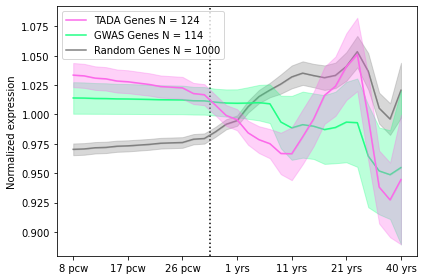

In [10]:
tada_df = pd.read_csv("/content/drive/MyDrive/antaki2021_manuscript/brainspan/tada_df.2021_11_19.csv")
magma_df = pd.read_csv("/content/drive/MyDrive/antaki2021_manuscript/brainspan/magma_df.csv")
brainspan_sample_df = pd.read_csv("/content/drive/MyDrive/antaki2021_manuscript/brainspan/brainspan_sample_df.csv")

### Plotting
def plot_lowess(df, ax, color, label, zorder):
    xpos = {x:i for i,x in enumerate(sorted( set(df['weeks'])))}
    xrev = {i:x for i,x in enumerate(sorted( set(df['weeks'])))}
    xlabs = dict(zip(df['weeks'], df['age']))
    
    df['xpos'] = df['weeks'].map(xlabs)
    sns.lineplot(
        data = df,
        x = 'xpos',
        y = 'norm_lowess',
        ax = ax,
        label = label,
        color = color,
        zorder = zorder,
    )
    ax.fill_between(
        df['xpos'],
        df['norm_lowess'] - 1.96*df['norm_lowess_stderr'],
        df['norm_lowess'] + 1.96*df['norm_lowess_stderr'],
        alpha = 0.3,
        color = color,
        zorder = zorder,
    )
    xticks = [x for x in range(0, 35, 5)]
    xticklabels = [ xlabs[xrev[x]] for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    return ax

# sns.set_style("whitegrid")
f, ax = plt.subplots(1,1)

# All Genes, GWAS Genes, TADA Genes
# palette = ['grey', 'cyan', 'mediumseagreen']

# ax = plot_lowess(dnm_df, ax, 'mediumaquamarine', 'DNM Genes', 30)
# ax = plot_lowess(inh_df, ax, 'coral', 'Inherited Genes', 29)
ax = plot_lowess(tada_df, ax, '#fc68ea', 'TADA Genes N = {}'.format(num_tada_genes), 29)
ax = plot_lowess(magma_df, ax, '#21ff85', 'GWAS Genes N = {}'.format(num_magma_genes), 28)
ax = plot_lowess(brainspan_sample_df, ax, 'grey', 'Random Genes N = {}'.format(num_brainspan_genes_rs), 27)

ymin, ymax = ax.set_ylim()

ax.vlines(x = 12.5, ymin = ymin, ymax = ymax, color = 'k', linestyle = ':')
ax.set_xlabel('')
ax.set_ylabel('Normalized expression')
f.tight_layout()
f.savefig('lowess_expression.png')
f.savefig('lowess_expression.svg')
f.savefig('lowess_expression.pdf')